#### Part2 튼튼한 GAN 만들기
---
Chapter 6. 단순한 1010 패턴

In [1]:
import torch
import torch.nn as nn

In [2]:
import pandas
import matplotlib.pyplot as plt

In [9]:
import random

def generate_real():
  real_data = torch.FloatTensor(
      [random.uniform(0.8, 1.0),
       random.uniform(0.0, 0.2),
       random.uniform(0.8, 1.0),
       random.uniform(0.0, 0.2)]
  )
  return real_data

generate_real()

tensor([0.8578, 0.1246, 0.8915, 0.1176])

In [20]:
class Discriminator(nn.Module):
  def __init__(self):
    # 파이토치 부모 클래스 초기화
    super().__init__()
    
    # 신경망 레이어 정의
    self.model = nn.Sequential(
        nn.Linear(4, 3),
        nn.Sigmoid(),
        nn.Linear(3, 1),
        nn.Sigmoid()
    )

    # 손실함수 설정
    self.loss_function = nn.MSELoss()
    
    # SGD 옵티마이저 설정
    self.optimiser = torch.optim.SGD(self.parameters(), lr = 0.01)

    # 진행 측정을 위한 변수 초기화
    self.counter = 0;
    self.progress = []

    pass

  def forward(self, inputs):
    # 모델 실행
    return self.model(inputs)

  def train(self, inputs, targets):
    # 신경망 출력 계산
    outputs = self.forward(inputs)

    # 손실 계산
    loss = self.loss_function(outputs, targets)

    # 카운터를 증가시키고 10회마다 오차 저장
    self.counter += 1;
    if(self.counter % 10 == 0):
      self.progress.append(loss.item())
      pass
    if(self.counter % 10000 == 0):
      print("counter = ", self.counter)
      pass
    
    # 기울기를 초기화하고 역전파 후 가중치 갱신
    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()
    
    pass

  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
    pass
  pass

In [11]:
def generate_random(size):
  random_data = torch.rand(size)
  return random_data

In [12]:
D = Discriminator()

for i in range(10000):
  # 실제 데이터
  D.train(generate_real(), torch.FloatTensor([1.0]))
  # 생성된 데이터
  D.train(generate_random(4), torch.FloatTensor([0.0]))
  pass

counter = 10000
counter = 20000


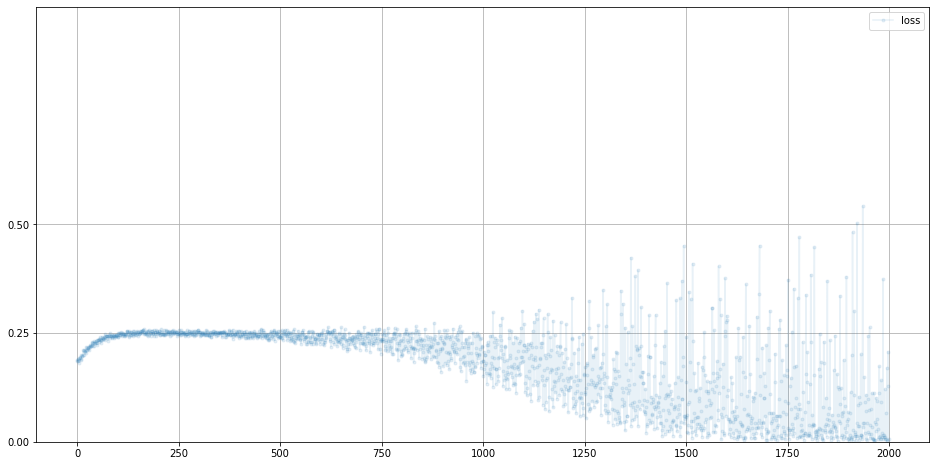

In [13]:
D.plot_progress()

In [14]:
# manually run discriminator to check it can tell real data from fake
print(D.forward(generate_real()).item())
print(D.forward(generate_random(4)).item())

0.7230117917060852
0.13558480143547058


In [28]:
class Generator(nn.Module):
  def __init__(self):
    # 파이토치 부모 클래스 초기화
    super().__init__()

    # 신경망 레이어 정의
    self.model = nn.Sequential(
        nn.Linear(1, 3),
        nn.Sigmoid(),
        nn.Linear(3, 4),
        nn.Sigmoid()
    )

    # SGD 옵티마이저 설정
    self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)

    # 진행 측정을 위한 변수 초기화
    self.counter = 0;
    self.progress = []

    pass

  def forward(self, inputs):
    # 모델 실행
    return self.model(inputs)

  def train(self, D, inputs, targets):
    # 신경망 출력 계산
    g_output = self.forward(inputs)

    # 판별기로 전달
    d_output = D.forward(g_output)

    # 오차 계산
    loss = D.loss_function(d_output, targets)

    # 카운터를 증가시키고 10회마다 오차 저장
    self.counter += 1
    if(self.counter % 10 == 0):
      self.progress.append(loss.item())
      pass

    # 기울기를 초기화하고 역전파 후 가중치 갱신
    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()
    pass

  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
    pass
  pass

In [29]:
# check the generator output is of the right type and shape
G = Generator()
G.forward(torch.FloatTensor([0.5]))

tensor([0.4966, 0.5171, 0.5197, 0.4251], grad_fn=<SigmoidBackward>)

In [35]:
# 판별기 및 생성기 생성
D = Discriminator()
G = Generator()

image_list = []

# 판별기와 생성기 훈련
for i in range(10000):
  # 1단계: 참에 대해 판별기 훈련
  D.train(generate_real(), torch.FloatTensor([1.0]))

  # 2단계: 거짓에 대해 판별기 훈련
  # G의 기울기가 계산되지 않도록 detach() 함수를 이용
  D.train(G.forward(torch.FloatTensor([0.5])).detach(), torch.FloatTensor([0.0]))

  # 3단계: 생성기 훈련
  G.train(D, torch.FloatTensor([0.5]), torch.FloatTensor([1.0]))

  # 매 1000회 이미지를 저장
  if (i % 1000 == 0):
    image_list.append(G.forward(torch.FloatTensor([0.5])).detach().numpy())
  
  pass

counter =  10000
counter =  20000


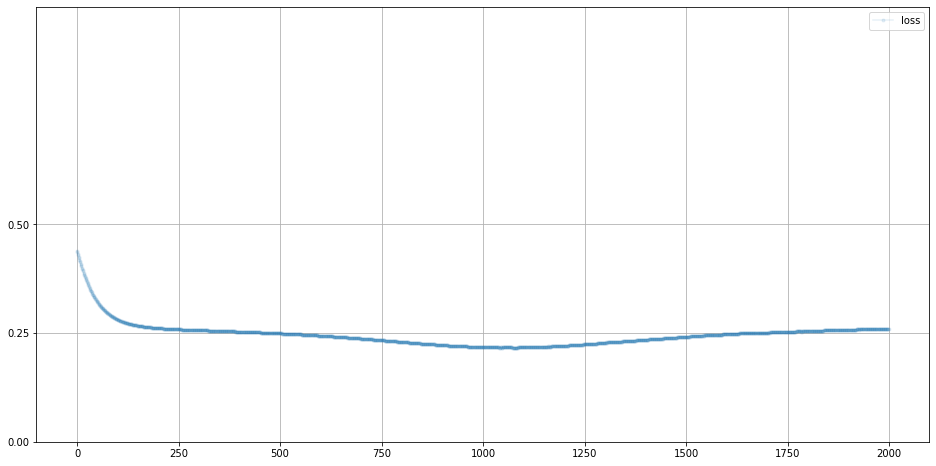

In [36]:
# plot discriminator eroor
D.plot_progress()

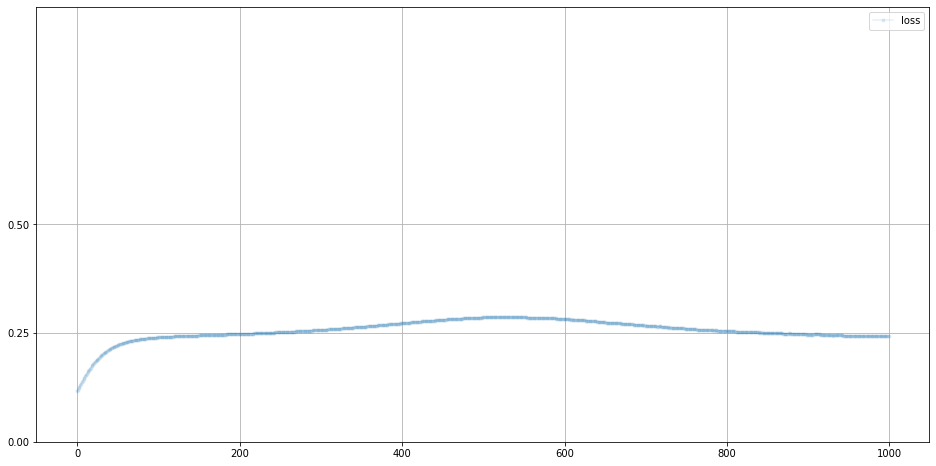

In [37]:
# plot generator error
G.plot_progress()

In [38]:
# manually run generator to see it's ouputs
G.forward(torch.FloatTensor([0.5]))

tensor([0.8905, 0.0654, 0.9325, 0.0595], grad_fn=<SigmoidBackward>)

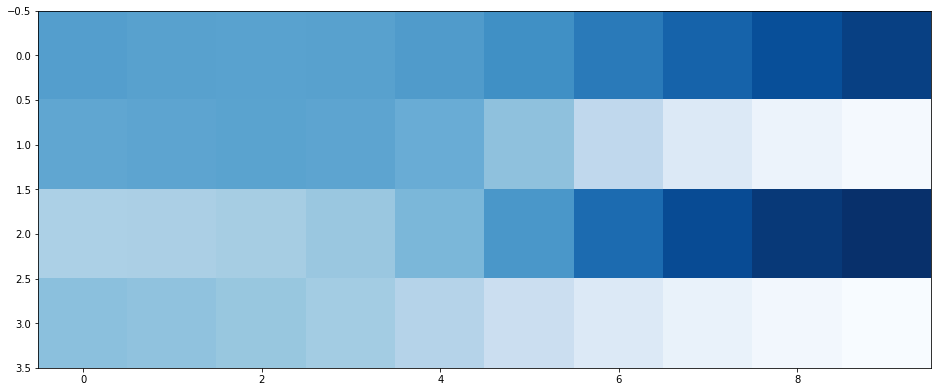

In [40]:
import numpy
plt.figure(figsize=(16,8))
plt.imshow(numpy.array(image_list).T, interpolation='none', cmap='Blues')